## MaxwellFDFD Data download
1. download data from link
2. make directory
3. unzip dataset

In [ ]:
# https://drive.google.com/file/d/1LabnwxMDQEWXo6-ZzUMrANvA6y4kB3dX/view?usp=sharing //download

In [10]:
!mkdir maxwellfdfd
!unzip maxwellfdfd.zip -d ./maxwellfdfd

스트리밍 출력 내용이 길어서 마지막 5000줄이 삭제되었습니다.
  inflating: ./maxwellfdfd/valid/binary_rl_fix_1012/541.tiff  
  inflating: ./maxwellfdfd/valid/binary_rl_fix_1012/111.tiff  
  inflating: ./maxwellfdfd/valid/binary_rl_fix_1012/49.tiff  
  inflating: ./maxwellfdfd/valid/binary_rl_fix_1012/812.tiff  
  inflating: ./maxwellfdfd/valid/binary_rl_fix_1012/957.tiff  
  inflating: ./maxwellfdfd/valid/binary_rl_fix_1012/404.tiff  
  inflating: ./maxwellfdfd/valid/binary_rl_fix_1013/305.tiff  
  inflating: ./maxwellfdfd/valid/binary_rl_fix_1013/755.tiff  
  inflating: ./maxwellfdfd/valid/binary_rl_fix_1013/240.tiff  
  inflating: ./maxwellfdfd/valid/binary_rl_fix_1013/610.tiff  
  inflating: ./maxwellfdfd/valid/binary_rl_fix_1013/31.tiff  
  inflating: ./maxwellfdfd/valid/binary_rl_fix_1013/539.tiff  
  inflating: ./maxwellfdfd/valid/binary_rl_fix_1013/493.tiff  
  inflating: ./maxwellfdfd/valid/binary_rl_fix_1013/169.tiff  
  inflating: ./maxwellfdfd/valid/binary_rl_fix_1013/186.tiff  
  inflating: ./maxwel

## WGAN modified of DCGAN in:
1. no log Loss (Wasserstein distance)
2. clip param norm to c (Wasserstein distance and Lipschitz continuity)

In [12]:
import numpy as np
import pandas as pd
import os

from PIL import Image
from typing import Any, Tuple
from torch.utils.data import DataLoader

import torch
import torch.utils.data
from torchvision.utils import make_grid
import matplotlib.pyplot as plt
%matplotlib inline

In [13]:
def compress_image(prev_image, n):
    if n < 2:
        return prev_image

    height = prev_image.shape[0] // n
    width = prev_image.shape[1] // n
    new_image = np.zeros((height, width), dtype="uint8")
    for i in range(0, height):
        for j in range(0, width):
            new_image[i, j] = prev_image[n * i, n * j]

    return new_image

class CEMDataset(torch.utils.data.Dataset):
    DATASETS_TRAIN = [
        'binary_501',
        'binary_502',
        'binary_503',
        'binary_504',
        'binary_505',
        'binary_506',
        'binary_507',
        'binary_508',
        'binary_509',
        'binary_510',
        'binary_511',
        'binary_512',
        'binary_1001',
        'binary_1002',
        'binary_1003',
    ]

    def __init__(self,
                 root: str,
                train: bool = True,
                scale: int = 1,
        is_regression: bool = True,
                 ) -> None:
        self.train = train
        self.root = root
        self.scale = scale
        self.width = 200 // scale
        self.height = 100 // scale
        self.is_regression = is_regression

        if self.train:
            DATAPATH = os.path.join(root, 'train')
            DATASETS = self.DATASETS_TRAIN
        else:
            DATAPATH = os.path.join(root, 'test')
            DATASETS = self.DATASETS_TEST

        self.data: Any = []
        self.targets = []

        print('data loading ... ')

        # load Train dataset
        for data in DATASETS:
            dataframe = pd.read_csv(os.path.join(DATAPATH, '{}.csv'.format(data)), delim_whitespace=False, header=None)
            dataset = dataframe.values

            # split into input (X) and output (Y) variables
            fileNames = dataset[:, 0]

            # 1. first try max
            dataset[:, 1:25] /= 2767.1
            
            # 2. Classification or Regression
            labels = dataset[:, 1:25]
            if self.is_regression:
                self.targets.extend(labels)
            else:
                labels = np.apply_along_axis(lambda x: np.argmax(x), 1, labels)
                self.targets.extend(labels)
                    
            for idx, file in enumerate(fileNames):
                try:
                    image = Image.open(os.path.join(DATAPATH, data, '{}.tiff'.format(int(file))))
                    image = np.array(image).astype(np.uint8)
                except (TypeError, FileNotFoundError) as te:
                    image = Image.open(os.path.join(DATAPATH, data, '{}.tiff'.format(idx + 1)))
                    try:
                        image = np.array(image).astype(np.uint8)
                    except:
                        continue
                image = compress_image(image, self.scale)
                self.data.append(np.array(image).flatten(order='C'))

        self.data = np.vstack(self.data).reshape(-1, 1, self.height, self.width)
        self.data = self.data.transpose((0, 1, 2, 3))  # convert to HWC CHW
        print(f'Data Loading Finished. len : {len(self.data)}')


    def __getitem__(self, index: int) -> Tuple[Any, Any]:
        """
        Args:
            index (int): Index

        Returns:
            tuple: (image, target) where target is index of the target class.
        """
        img, target = self.data[index], self.targets[index]

        return img, target

    def __len__(self) -> int:
        return len(self.data)

In [14]:
data_dir = os.path.join(os.getcwd(), 'maxwellfdfd')
data_dir

'/content/maxwellfdfd'

In [15]:
cem_train = CEMDataset(data_dir, train=True, scale=5, is_regression = True)

data loading ... 
Data Loading Finished. len : 9000


In [16]:
batch_size = 128
train_dl = DataLoader(cem_train, batch_size, shuffle=True, pin_memory=True)

Let's create helper functions to denormalize the image tensors and display some sample images from a training batch.

In [17]:
def denorm(img_tensors):
    return img_tensors * 1.

In [18]:
def show_images(images, nmax=64):
    fig, ax = plt.subplots(figsize=(8, 8))
    ax.set_xticks([]); ax.set_yticks([])
    s = make_grid(images.detach()[:nmax], nrow=8)
    ax.imshow(make_grid(denorm(images.detach()[:nmax]), nrow=8, padding=5, pad_value=0.5).permute(1, 2, 0))

def show_batch(dl, nmax=64):
    for images, _ in dl:
        show_images(images, nmax)
        break

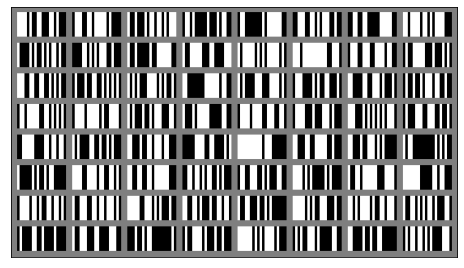

In [19]:
show_batch(train_dl)

## Using a GPU

To seamlessly use a GPU, if one is available, we define a couple of helper functions (`get_default_device` & `to_device`) and a helper class `DeviceDataLoader` to move our model & data to the GPU, if one is available.

In [20]:
def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')
    
def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl: 
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)

Based on where you're running this notebook, your default device could be a CPU (`torch.device('cpu')`) or a GPU (`torch.device('cuda')`).

In [21]:
device = get_default_device()
device

device(type='cpu')

We can now move our training data loader using `DeviceDataLoader` for automatically transferring batches of data to the GPU (if available).

In [22]:
train_dl = DeviceDataLoader(train_dl, device)

## Discriminator Network

The discriminator takes an image as input, and tries to classify it as "real" or "generated". In this sense, it's like any other neural network. We'll use a convolutional neural networks (CNN) which outputs a single number output for every image. We'll use stride of 2 to progressively reduce the size of the output feature map.

![](https://github.com/vdumoulin/conv_arithmetic/raw/master/gif/padding_strides_odd.gif)

In [23]:
import torch.nn as nn

In [24]:
discriminator = nn.Sequential(
    # in: 1 x 20 x 40

    nn.Conv2d(1, 64, kernel_size=4, stride=2, padding=(0, 1), bias=False),
    nn.LeakyReLU(0.2, inplace=True),

    nn.Conv2d(64, 128, kernel_size=(3, 4), stride=2, padding=1, bias=False),
    nn.BatchNorm2d(128),
    nn.LeakyReLU(0.2, inplace=True),

    nn.Conv2d(128, 256, kernel_size=(3, 4), stride=2, padding=1, bias=False),
    nn.BatchNorm2d(256),
    nn.LeakyReLU(0.2, inplace=True),

    nn.Conv2d(256, 1, kernel_size=(3, 5), stride=1, padding=0, bias=False),
    # out: 1 x 1 x 1
    
    nn.Flatten(),
    nn.Sigmoid()

    )
print(discriminator)

Sequential(
  (0): Conv2d(1, 64, kernel_size=(4, 4), stride=(2, 2), padding=(0, 1), bias=False)
  (1): LeakyReLU(negative_slope=0.2, inplace=True)
  (2): Conv2d(64, 128, kernel_size=(3, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (4): LeakyReLU(negative_slope=0.2, inplace=True)
  (5): Conv2d(128, 256, kernel_size=(3, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (6): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (7): LeakyReLU(negative_slope=0.2, inplace=True)
  (8): Conv2d(256, 1, kernel_size=(3, 5), stride=(1, 1), bias=False)
  (9): Flatten(start_dim=1, end_dim=-1)
  (10): Sigmoid()
)


Note that we're using the Leaky ReLU activation for the discriminator.

<img src="https://cdn-images-1.medium.com/max/1600/1*ypsvQH7kvtI2BhzR2eT_Sw.png" width="420">


>  Different from the regular ReLU function, Leaky ReLU allows the pass of a small gradient signal for negative values. As a result, it makes the gradients from the discriminator flows stronger into the generator. Instead of passing a gradient (slope) of 0 in the back-prop pass, it passes a small negative gradient.  - [Source](https://sthalles.github.io/advanced_gans/)

Just like any other binary classification model, the output of the discriminator is a single number between 0 and 1, which can be interpreted as the probability of the input image being real i.e. picked from the original dataset.

Let's move the discriminator model to the chosen device.

In [25]:
discriminator = to_device(discriminator, device)

## Generator Network

The input to the generator is typically a vector or a matrix of random numbers (referred to as a latent tensor) which is used as a seed for generating an image. The generator will convert a latent tensor of shape `(128, 1, 1)` into an image tensor of shape `3 x 28 x 28`. To achive this, we'll use the `ConvTranspose2d` layer from PyTorch, which is performs to as a *transposed convolution* (also referred to as a *deconvolution*). [Learn more](https://github.com/vdumoulin/conv_arithmetic/blob/master/README.md#transposed-convolution-animations)

![](https://i.imgur.com/DRvK546.gif)

In [26]:
latent_size = 128

In [27]:
generator = nn.Sequential(
    # in: latent_size x 1 x 1
    nn.ConvTranspose2d(latent_size, 256, kernel_size=(3,5), stride=1, padding=0, bias=False),
    nn.BatchNorm2d(256),
    nn.ReLU(True),

    nn.ConvTranspose2d(256, 128, kernel_size=(3,4), stride=2, padding=1, bias=False),
    nn.BatchNorm2d(128),
    nn.ReLU(True),

    nn.ConvTranspose2d(128, 64, kernel_size=(3,4), stride=2, padding=1, bias=False),
    nn.BatchNorm2d(64),
    nn.ReLU(True),

    nn.ConvTranspose2d(64, 1, kernel_size=(4,4), stride=2, padding=(0, 1), bias=False),
    nn.Tanh()
    # out: 1 x 20 x 40
)

We use the TanH activation function for the output layer of the generator.

<img src="https://nic.schraudolph.org/teach/NNcourse/figs/tanh.gif" width="420" >

> "The ReLU activation (Nair & Hinton, 2010) is used in the generator with the exception of the output layer which uses the Tanh function. We observed that using a bounded activation allowed the model to learn more quickly to saturate and cover the color space of the training distribution. Within the discriminator we found the leaky rectified activation (Maas et al., 2013) (Xu et al., 2015) to work well, especially for higher resolution modeling." - [Source](https://stackoverflow.com/questions/41489907/generative-adversarial-networks-tanh)


Note that since the outputs of the TanH activation lie in the range `[-1,1]`, we have applied the similar transformation to the images in the training dataset. Let's generate some outputs using the generator and view them as images by transforming and denormalizing the output.

In [28]:
def weight_init(m):
    # weight_initialization: important for wgan
    class_name=m.__class__.__name__
    if class_name.find('Conv')!=-1:
        m.weight.data.normal_(0,0.02)
    elif class_name.find('Norm')!=-1:
        m.weight.data.normal_(1.0,0.02)

In [29]:
discriminator.apply(weight_init)
generator.apply(weight_init)

Sequential(
  (0): ConvTranspose2d(128, 256, kernel_size=(3, 5), stride=(1, 1), bias=False)
  (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): ReLU(inplace=True)
  (3): ConvTranspose2d(256, 128, kernel_size=(3, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (4): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (5): ReLU(inplace=True)
  (6): ConvTranspose2d(128, 64, kernel_size=(3, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (7): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (8): ReLU(inplace=True)
  (9): ConvTranspose2d(64, 1, kernel_size=(4, 4), stride=(2, 2), padding=(0, 1), bias=False)
  (10): Tanh()
)

torch.Size([128, 1, 20, 40])


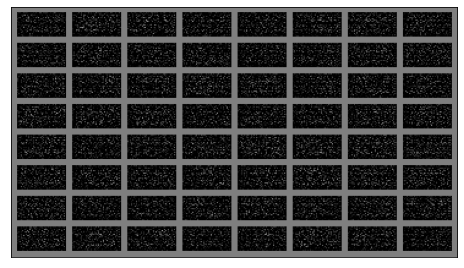

In [30]:
xb = torch.randn(batch_size, latent_size, 1, 1) # random latent tensors
fake_images = generator(xb)
print(fake_images.shape)
show_images(fake_images)

As one might expect, the output from the generator is basically random noise, since we haven't trained it yet. 

Let's move the generator to the chosen device.

In [31]:
generator = to_device(generator, device)

## Discriminator Training



In [32]:
def train_discriminator(real_images, opt_d):
    # Clear discriminator gradients
    opt_d.zero_grad()

    # Pass real images through discriminator
    real_preds = discriminator(real_images.float())
    
    real_preds = real_preds.view(-1, 1)
    real_targets = torch.ones(real_images.size(0), 1, device=device)
    real_loss = F.binary_cross_entropy(real_preds, real_targets)
    real_score = torch.mean(real_preds).item()

    # Generate fake images
    latent = torch.randn(batch_size, latent_size, 1, 1, device=device)
    fake_images = generator(latent)

    # Pass fake images through discriminator
    fake_preds = discriminator(fake_images)
    fake_targets = torch.zeros(fake_images.size(0), 1, device=device)
    fake_loss = F.binary_cross_entropy(fake_preds, fake_targets)
    fake_score = torch.mean(fake_preds).item()

    # Update discriminator weights
    loss = real_loss + fake_loss
    loss.backward()
    opt_d.step()
    return loss.item(), real_loss.item(), fake_loss.item()

Here are the steps involved in training the discriminator.

- We expect the discriminator to output 1 if the image was picked from the real MNIST dataset, and 0 if it was generated using the generator network. 

- We first pass a batch of real images, and compute the loss, setting the target labels to 1. 

- Then we pass a batch of fake images (generated using the generator) pass them into the discriminator, and compute the loss, setting the target labels to 0. 

- Finally we add the two losses and use the overall loss to perform gradient descent to adjust the weights of the discriminator.

It's important to note that we don't change the weights of the generator model while training the discriminator (`opt_d` only affects the `discriminator.parameters()`)

## Generator Training

Since the outputs of the generator are images, it's not obvious how we can train the generator. This is where we employ a rather elegant trick, which is to use the discriminator as a part of the loss function. Here's how it works:

- We generate a batch of images using the generator, pass the into the discriminator.

- We calculate the loss by setting the target labels to 1 i.e. real. We do this because the generator's objective is to "fool" the discriminator. 

- We use the loss to perform gradient descent i.e. change the weights of the generator, so it gets better at generating real-like images to "fool" the discriminator.

Here's what this looks like in code.

In [33]:
def train_generator(opt_g):
    # Clear generator gradients
    opt_g.zero_grad()
    
    # Generate fake images
    latent = torch.randn(batch_size, latent_size, 1, 1, device=device)
    fake_images = generator(latent)
    
    # Try to fool the discriminator
    preds = discriminator(fake_images)
    targets = torch.ones(batch_size, 1, device=device)
    loss = F.binary_cross_entropy(preds, targets)
    
    # Update generator weights
    loss.backward()
    opt_g.step()
    
    return loss.item()

Let's create a directory where we can save intermediate outputs from the generator to visually inspect the progress of the model. We'll also create a helper function to export the generated images.

In [34]:
from torchvision.utils import save_image

In [35]:
sample_dir = 'generated'
os.makedirs(sample_dir, exist_ok=True)

In [36]:
def save_samples(index, latent_tensors, show=True):
    fake_images = generator(latent_tensors)
    fake_fname = 'generated-images-{0:0=4d}.png'.format(index)
    save_image(denorm(fake_images), os.path.join(sample_dir, fake_fname), nrow=8)
    print('Saving', fake_fname)
    if show:
        fig, ax = plt.subplots(figsize=(8, 8))
        ax.set_xticks([]); ax.set_yticks([])
        ax.imshow(make_grid(fake_images.cpu().detach(), nrow=8).permute(1, 2, 0))

We'll use a fixed set of input vectors to the generator to see how the individual generated images evolve over time as we train the model. Let's save one set of images before we start training our model.

In [37]:
fixed_latent = torch.randn(64, latent_size, 1, 1, device=device)

Saving generated-images-0000.png


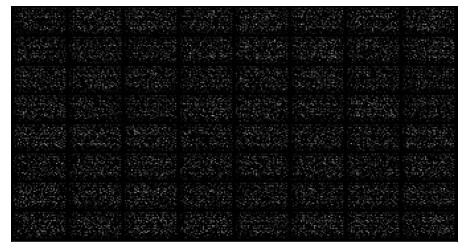

In [38]:
save_samples(0, fixed_latent)

## Full Training Loop

Let's define a `fit` function to train the discriminator and generator in tandem for each batch of training data. We'll use the Adam optimizer with some custom parameters (betas) that are known to work well for GANs. We will also save some sample generated images at regular intervals for inspection.

In [39]:
from tqdm.notebook import tqdm
import torch.nn.functional as F

In [40]:
def fit(epochs, lr, start_idx=1):
    torch.cuda.empty_cache()
    
    # Losses & scores
    losses_g = []
    losses_d = []
    real_scores = []
    fake_scores = []
    
    # Create optimizers
    opt_d = torch.optim.Adam(discriminator.parameters(), lr=lr, betas=(0.5, 0.999))
    opt_g = torch.optim.Adam(generator.parameters(), lr=lr,  betas=(0.5, 0.999))
    
    
    
    for epoch in range(epochs):
        for real_images, _ in tqdm(train_dl):
            # Train discriminator
            # modification: clip param for discriminator
            for parm in discriminator.parameters():
                parm.data.clamp_(-clamp_num, clamp_num)
            loss_d, real_score, fake_score = train_discriminator(real_images, opt_d)
            # Train generator
            loss_g = train_generator(opt_g)
            
        # Record losses & scores
        losses_g.append(loss_g)
        losses_d.append(loss_d)
        real_scores.append(real_score)
        fake_scores.append(fake_score)
        
        # Log losses & scores (last batch)
        print("Epoch [{}/{}], loss_g: {:.4f}, loss_d: {:.4f}, real_score: {:.4f}, fake_score: {:.4f}".format(
            epoch+1, epochs, loss_g, loss_d, real_score, fake_score))
    
        # Save generated images
        save_samples(epoch+start_idx, fixed_latent, show=False)
    
    return losses_g, losses_d, real_scores, fake_scores

We are now ready to train the model. Try different learning rates to see if you can maintain the fine balance between the training the generator and the discriminator.

In [41]:
lr = 0.0002
epochs = 25
clamp_num=0.01# WGAN clip gradient

In [ ]:
history = fit(epochs, lr)

  0%|          | 0/71 [00:00<?, ?it/s]

Epoch [1/25], loss_g: 0.8327, loss_d: 1.2225, real_score: 0.6159, fake_score: 0.6067
Saving generated-images-0001.png


  0%|          | 0/71 [00:00<?, ?it/s]

Epoch [2/25], loss_g: 0.8313, loss_d: 1.1819, real_score: 0.5985, fake_score: 0.5835
Saving generated-images-0002.png


  0%|          | 0/71 [00:00<?, ?it/s]

Epoch [3/25], loss_g: 0.8294, loss_d: 1.2526, real_score: 0.6015, fake_score: 0.6511
Saving generated-images-0003.png


  0%|          | 0/71 [00:00<?, ?it/s]

Epoch [4/25], loss_g: 0.8280, loss_d: 1.2104, real_score: 0.6019, fake_score: 0.6085
Saving generated-images-0004.png


  0%|          | 0/71 [00:00<?, ?it/s]

In [ ]:
losses_g, losses_d, real_scores, fake_scores = history

Now that we have trained the models, we can save checkpoints.

In [ ]:
# Save the model checkpoints 
torch.save(generator.state_dict(), 'G.pth')
torch.save(discriminator.state_dict(), 'D.pth')

Here's how the generated images look, after the 1st, 5th and 10th epochs of training.

In [ ]:
from IPython.display import Image

In [ ]:
Image('./generated/generated-images-0025.png')

We can visualize the training process by combining the sample images generated after each epoch into a video using OpenCV.

In [ ]:
import os
import imageio

vid_fname = 'gans_training.gif'

files = [os.path.join(sample_dir, f) for f in os.listdir(sample_dir) if 'generated' in f]
files.sort()

images = []
for filename in files:
    images.append(imageio.imread(filename))
imageio.mimsave(vid_fname, images)


In [ ]:
def show_gif(fname):
    import base64
    from IPython import display
    with open(fname, 'rb') as fd:
        b64 = base64.b64encode(fd.read()).decode('ascii')
    return display.HTML(f'<img src="data:image/gif;base64,{b64}" />')

show_gif('./gans_training.gif')

Here's what it looks like:

![]()


We can also visualize how the loss changes over time. Visualizing 
losses is quite useful for debugging the training process. For GANs, we expect the generator's loss to reduce over time, without the discriminator's loss getting too high.



In [ ]:
plt.plot(losses_d, '-')
plt.plot(losses_g, '-')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['Discriminator', 'Generator'])
plt.title('Losses');

In [ ]:
plt.plot(real_scores, '-')
plt.plot(fake_scores, '-')
plt.xlabel('epoch')
plt.ylabel('score')
plt.legend(['Real', 'Fake'])
plt.title('Scores');